# Bias-Aware and Explainable Deep Learning Model for Early Detection of Alzheimer's Disease using MRI Scans

**Research Project: B.Tech CSE - Problem Based Learning**

---

## Project Overview

This notebook implements a comprehensive deep learning solution for Alzheimer's Disease detection using MRI scans with:
- Transfer Learning (DenseNet121)
- DCGAN for handling class imbalance
- Explainable AI (Grad-CAM & SHAP)
- Bias & Fairness Analysis

**Dataset:** Augmented Alzheimer MRI Dataset from Kaggle

**Classes:**
1. NonDemented
2. VeryMildDemented
3. MildDemented
4. ModerateDemented

---
## 1. Environment Setup
### Check GPU Availability

In [3]:
!nvidia-smi

Tue Feb 17 10:04:25 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install Required Libraries

In [4]:
!pip install -q shap opencv-python-headless kaggle
!pip install -q tensorflow>=2.16.0

### Import Libraries

In [5]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from glob import glob
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization, GlobalAveragePooling2D,
    Conv2D, Conv2DTranspose, LeakyReLU, Reshape, Flatten, Input
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Scikit-learn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Explainability libraries
import shap

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


---
## 2. Dataset Download & Structure

### Upload Kaggle API Credentials

**Instructions:**
1. Go to Kaggle → Account → API → Create New API Token
2. Upload the downloaded `kaggle.json` file when prompted

In [6]:
from google.colab import files

# Upload kaggle.json
uploaded = files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### Download Dataset from Kaggle

In [7]:
# Download the dataset
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset

# Unzip the dataset
!unzip -q augmented-alzheimer-mri-dataset.zip -d alzheimer_dataset

print("Dataset downloaded and extracted successfully!")

Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset
License(s): GNU Lesser General Public License 3.0
 78% 296M/380M [00:00<00:00, 813MB/s] 
100% 380M/380M [00:00<00:00, 655MB/s]
Dataset downloaded and extracted successfully!


### Verify Dataset Structure

In [8]:
# List directory structure
!ls -R alzheimer_dataset/

Streaming output truncated to the last 5000 lines.
a27da9a4-1ed4-493f-af81-dd8a3c8adda2.jpg
a280d3f6-c18d-424e-8f51-e924f5392c74.jpg
a28780ec-8fc0-4d55-9596-0ae2663c6da4.jpg
a293bcd0-b371-4120-a3b5-f8c763b0fa95.jpg
a296a0bd-4784-4d26-ba1f-3e2c53bf0234.jpg
a296eb7c-0d47-49a3-9acf-7898766ccaac.jpg
a2ae1710-fd4e-47c1-8255-170ea4c3e093.jpg
a2af5755-45ef-432a-b248-76936fa00ea2.jpg
a2bc912d-2199-4499-85dd-1d26c6068b44.jpg
a2ce3d1d-e633-4376-a984-e544e77d24a8.jpg
a2dbdc66-ceb0-4f4a-b963-2a89f87e130f.jpg
a2df4468-c05a-4e90-94e1-c06f40fde0ce.jpg
a2e3d8c6-e67c-49d3-9f19-0e3ee8faef77.jpg
a2e59355-95a7-47fd-997f-992e8d840a78.jpg
a2e5e50c-782d-4fc4-b733-f532659ad66f.jpg
a2e6ce54-28db-4fb3-97d1-e9d302e76de2.jpg
a2f56356-b791-4801-8051-77632df505b1.jpg
a2f94ee1-e841-4cf9-b56d-26e5a2378215.jpg
a2fa4c85-e9f8-4668-aa8e-f7b817200bae.jpg
a3051193-f2fe-49d6-ac01-ee45d568fc57.jpg
a307a69d-a002-43cd-84a7-e9096c97c092.jpg
a308b58d-905c-4323-ab1d-3fbee1e5b7d9.jpg
a314719f-de43-4967-b0f2-5cec148a4185.jpg
a31694

### Define Dataset Paths Dynamically

In [9]:
# Find the actual dataset path
base_path = 'alzheimer_dataset'

# Look for train/test directories
possible_paths = [
    os.path.join(base_path, 'AugmentedAlzheimerDataset'),
    os.path.join(base_path, 'augmented-alzheimer-mri-dataset'),
    base_path
]

DATASET_PATH = None
for path in possible_paths:
    if os.path.exists(path):
        subdirs = os.listdir(path)
        if any(d in subdirs for d in ['train', 'test', 'Train', 'Test']):
            DATASET_PATH = path
            break

if DATASET_PATH is None:
    # Fallback: find any directory with subdirectories
    for root, dirs, files in os.walk(base_path):
        if len(dirs) >= 2:
            DATASET_PATH = root
            break

print(f"Dataset Path: {DATASET_PATH}")
print(f"\nContents: {os.listdir(DATASET_PATH)}")

# Define train and test paths
train_dirs = [d for d in os.listdir(DATASET_PATH) if 'train' in d.lower()]
test_dirs = [d for d in os.listdir(DATASET_PATH) if 'test' in d.lower()]

TRAIN_PATH = os.path.join(DATASET_PATH, train_dirs[0]) if train_dirs else None
TEST_PATH = os.path.join(DATASET_PATH, test_dirs[0]) if test_dirs else None

print(f"\nTrain Path: {TRAIN_PATH}")
print(f"Test Path: {TEST_PATH}")

# Verify class folders
if TRAIN_PATH:
    print(f"\nClasses in Train: {os.listdir(TRAIN_PATH)}")

Dataset Path: alzheimer_dataset

Contents: ['OriginalDataset', 'AugmentedAlzheimerDataset']

Train Path: None
Test Path: None


### Explore Dataset Statistics

In [10]:
import os

print("Checking if alzheimer_dataset folder exists...")
if os.path.exists('alzheimer_dataset'):
    print("✓ alzheimer_dataset folder found\n")

    print("Complete contents:")
    print("="*60)

    for root, dirs, files in os.walk('alzheimer_dataset'):
        level = root.replace('alzheimer_dataset', '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)

        # Only show first 5 files per directory
        for file in files[:5]:
            print(f'{subindent}{file}')
        if len(files) > 5:
            print(f'{subindent}... and {len(files)-5} more files')

        # Stop after showing 3 levels deep
        if level >= 2:
            dirs[:] = []

    print("="*60)
else:
    print("✗ alzheimer_dataset folder NOT found!")
    print("\nCurrent directory contents:")
    print(os.listdir('.'))

Checking if alzheimer_dataset folder exists...
✓ alzheimer_dataset folder found

Complete contents:
alzheimer_dataset/
  OriginalDataset/
    MildDemented/
      mildDem185.jpg
      mildDem343.jpg
      mildDem76.jpg
      mildDem310.jpg
      mildDem156.jpg
      ... and 891 more files
    VeryMildDemented/
      32 (43).jpg
      verymildDem1348.jpg
      verymildDem1478.jpg
      31 (37).jpg
      verymildDem1391.jpg
      ... and 2235 more files
    NonDemented/
      32 (43).jpg
      nonDem10.jpg
      nonDem1729.jpg
      nonDem782.jpg
      nonDem2126.jpg
      ... and 3195 more files
    ModerateDemented/
      moderateDem2.jpg
      moderateDem16.jpg
      moderateDem5.jpg
      moderateDem6.jpg
      moderateDem34.jpg
      ... and 59 more files
  AugmentedAlzheimerDataset/
    MildDemented/
      67cac832-1a97-49ff-97a6-a62774f8ee4c.jpg
      a2502d00-6f55-487d-b55b-3b9832d7e805.jpg
      308a1f8a-2785-4963-9f0a-5bdf98400dec.jpg
      9a624ab3-0de9-4932-8cf4-b75136af24d6.j

✓ Dataset Path: alzheimer_dataset/AugmentedAlzheimerDataset

Classes found: ['MildDemented', 'VeryMildDemented', 'NonDemented', 'ModerateDemented']

Class Distribution:
----------------------------------------
MildDemented             :  8960 images
ModerateDemented         :  6464 images
NonDemented              :  9600 images
VeryMildDemented         :  8960 images

Total Images: 33984

Creating train/test split (80/20)...

MildDemented:
  Train: 7168 images
  Test: 1792 images

VeryMildDemented:
  Train: 7168 images
  Test: 1792 images

NonDemented:
  Train: 7680 images
  Test: 1920 images

ModerateDemented:
  Train: 5171 images
  Test: 1293 images

✓ Train/test split created successfully!
✓ Train Path: alzheimer_dataset/train
✓ Test Path: alzheimer_dataset/test
Class Distribution in Training Set:
----------------------------------------
MildDemented             :  7168 images
ModerateDemented         :  5171 images
NonDemented              :  7680 images
VeryMildDemented         : 

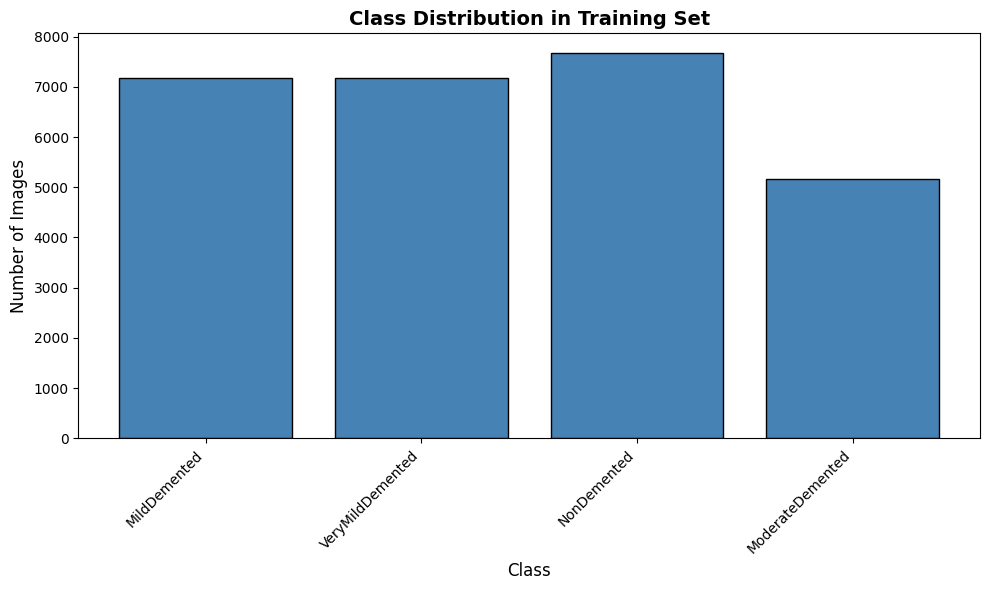


Total Training Images: 27187


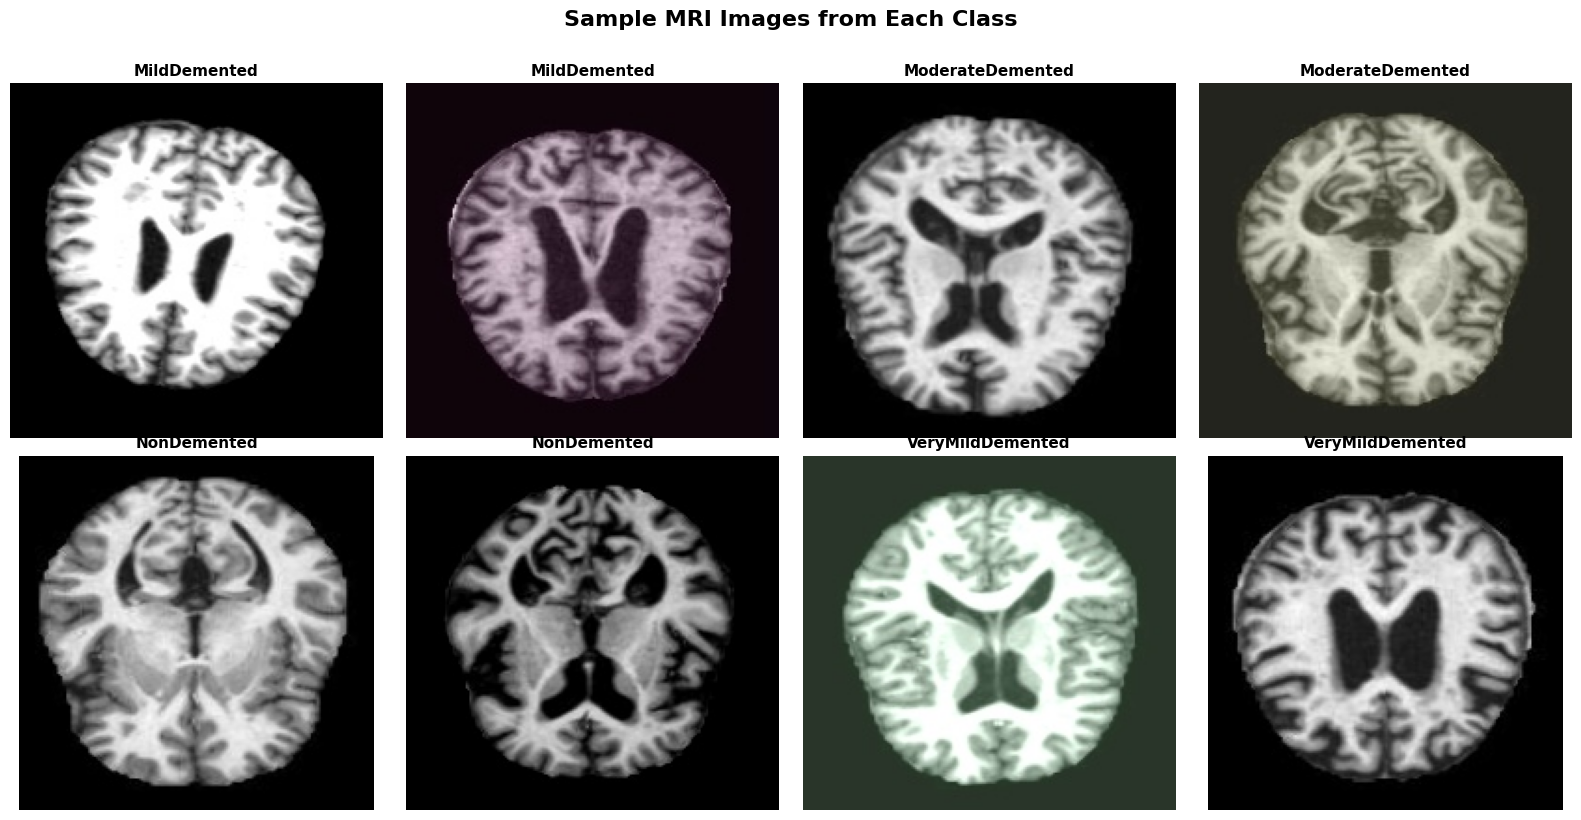

In [11]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import shutil

# Use the augmented dataset (larger and better)
DATASET_PATH = 'alzheimer_dataset/AugmentedAlzheimerDataset'

print(f"✓ Dataset Path: {DATASET_PATH}")
print(f"\nClasses found: {os.listdir(DATASET_PATH)}\n")

# Count images per class
classes = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
class_counts = {}

for cls in classes:
    class_path = os.path.join(DATASET_PATH, cls)
    count = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])
    class_counts[cls] = count

print("Class Distribution:")
print("-" * 40)
for cls, count in sorted(class_counts.items()):
    print(f"{cls:25s}: {count:5d} images")
print(f"\nTotal Images: {sum(class_counts.values())}")

# Since there's no train/test split, we'll create it
# Create train/test directories
print("\nCreating train/test split (80/20)...")

TRAIN_PATH = 'alzheimer_dataset/train'
TEST_PATH = 'alzheimer_dataset/test'

# Create directories if they don't exist
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(TEST_PATH, exist_ok=True)

for cls in classes:
    os.makedirs(os.path.join(TRAIN_PATH, cls), exist_ok=True)
    os.makedirs(os.path.join(TEST_PATH, cls), exist_ok=True)

# Split and copy files
np.random.seed(42)

for cls in classes:
    source_path = os.path.join(DATASET_PATH, cls)
    all_files = [f for f in os.listdir(source_path) if f.endswith('.jpg')]

    # 80% train, 20% test
    train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)

    print(f"\n{cls}:")
    print(f"  Train: {len(train_files)} images")
    print(f"  Test: {len(test_files)} images")

    # Copy to train
    for f in train_files:
        src = os.path.join(source_path, f)
        dst = os.path.join(TRAIN_PATH, cls, f)
        if not os.path.exists(dst):  # Skip if already copied
            shutil.copy2(src, dst)

    # Copy to test
    for f in test_files:
        src = os.path.join(source_path, f)
        dst = os.path.join(TEST_PATH, cls, f)
        if not os.path.exists(dst):  # Skip if already copied
            shutil.copy2(src, dst)

print("\n✓ Train/test split created successfully!")
print(f"✓ Train Path: {TRAIN_PATH}")
print(f"✓ Test Path: {TEST_PATH}")
import matplotlib.pyplot as plt

# Count images per class in training set
classes = [d for d in os.listdir(TRAIN_PATH) if os.path.isdir(os.path.join(TRAIN_PATH, d))]
class_counts = {}

for cls in classes:
    class_path = os.path.join(TRAIN_PATH, cls)
    count = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])
    class_counts[cls] = count

# Display counts
print("Class Distribution in Training Set:")
print("-" * 40)
for cls, count in sorted(class_counts.items()):
    print(f"{cls:25s}: {count:5d} images")

# Visualize distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='steelblue', edgecolor='black')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Class Distribution in Training Set', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nTotal Training Images: {sum(class_counts.values())}")

import cv2
import random

# Display sample images from each class
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, cls in enumerate(sorted(classes)):
    class_path = os.path.join(TRAIN_PATH, cls)
    images = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

    if images:
        # Load 2 random images per class
        for i in range(2):
            img_path = os.path.join(class_path, random.choice(images))
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[idx * 2 + i].imshow(img)
            axes[idx * 2 + i].set_title(cls, fontsize=11, fontweight='bold')
            axes[idx * 2 + i].axis('off')

plt.suptitle('Sample MRI Images from Each Class', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 3. Data Preprocessing & Augmentation

### Configure Image Data Generators

In [12]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)

# Test data (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Data generators configured successfully!")

Data generators configured successfully!


### Create Data Generators

In [13]:
# Training generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Print class indices
print("\nClass Indices:")
print(train_generator.class_indices)

# Create reverse mapping
class_names = {v: k for k, v in train_generator.class_indices.items()}
print("\nClass Names Mapping:")
print(class_names)

Found 21751 images belonging to 4 classes.
Found 5436 images belonging to 4 classes.
Found 6797 images belonging to 4 classes.

Class Indices:
{'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}

Class Names Mapping:
{0: 'MildDemented', 1: 'ModerateDemented', 2: 'NonDemented', 3: 'VeryMildDemented'}


### Visualize Augmented Images

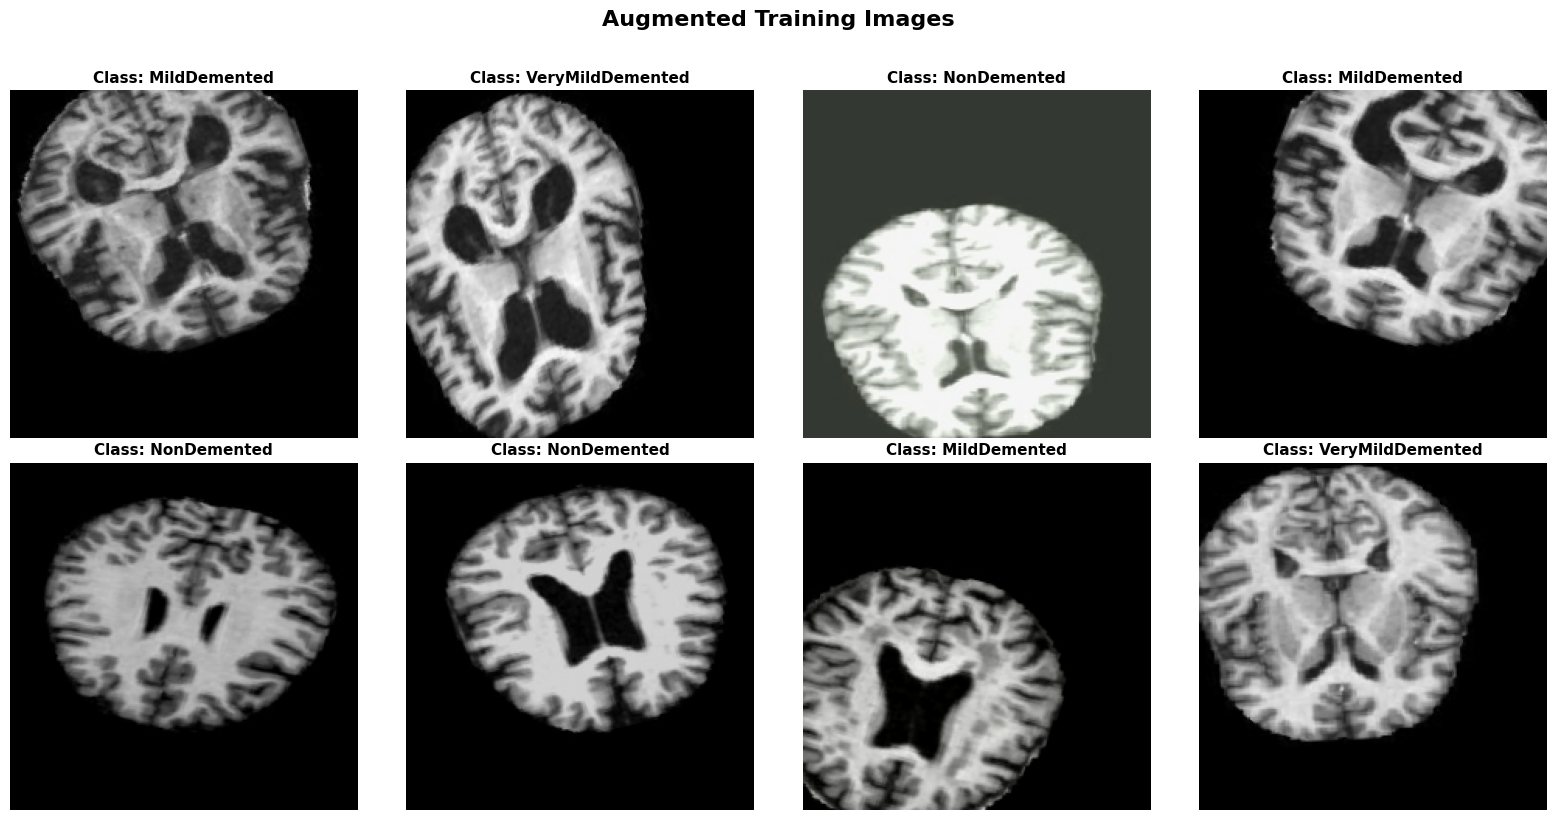

In [14]:
# Get a batch of augmented images
sample_batch, sample_labels = next(train_generator)

# Display augmented images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i in range(8):
    axes[i].imshow(sample_batch[i])
    class_idx = np.argmax(sample_labels[i])
    axes[i].set_title(f"Class: {class_names[class_idx]}", fontsize=11, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Augmented Training Images', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 4. DCGAN for Class Imbalance

### Purpose of DCGAN

Deep Convolutional Generative Adversarial Networks (DCGAN) are used to generate synthetic MRI images for minority classes, helping to balance the dataset and improve model generalization. The GAN consists of:

1. **Generator**: Creates realistic fake MRI images from random noise
2. **Discriminator**: Distinguishes between real and generated images

Through adversarial training, the generator learns to create increasingly realistic MRI scans that can augment underrepresented classes.

### Build Generator Network

In [15]:
def build_generator(latent_dim=100):
    """
    Build the Generator network for DCGAN.

    Args:
        latent_dim: Dimension of the input noise vector

    Returns:
        Generator model
    """
    model = Sequential([
        # Input: noise vector (100,)
        Dense(7 * 7 * 256, input_dim=latent_dim),
        LeakyReLU(alpha=0.2),
        Reshape((7, 7, 256)),

        # Upsample to 14x14
        Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        # Upsample to 28x28
        Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        # Upsample to 56x56
        Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        # Upsample to 112x112
        Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        # Upsample to 224x224
        Conv2DTranspose(32, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        # Output layer: 224x224x3
        Conv2D(3, kernel_size=7, padding='same', activation='tanh')
    ], name='Generator')

    return model

# Build and display generator
latent_dim = 100
generator = build_generator(latent_dim)
generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,266,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 56, 56, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 112, 112, 64)   │        65,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 224, 224, 32)   │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 3)    │         4,707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,289,539 (8.73 MB)

 Trainable params: 2,288,707 (8.73 MB)

 Non-trainable params: 832 (3.25 KB)

### Build Discriminator Network

In [16]:
def build_discriminator(img_shape=(224, 224, 3)):
    """
    Build the Discriminator network for DCGAN.

    Args:
        img_shape: Shape of input images

    Returns:
        Discriminator model
    """
    model = Sequential([
        # Input: 224x224x3
        Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=img_shape),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),

        # 112x112x64
        Conv2D(128, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),

        # 56x56x128
        Conv2D(256, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),

        # 28x28x256
        Conv2D(512, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),

        # Flatten and output
        Flatten(),
        Dense(1, activation='sigmoid')
    ], name='Discriminator')

    return model

# Build and display discriminator
discriminator = build_discriminator()
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       100,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,860,481 (10.91 MB)

 Trainable params: 2,858,689 (10.91 MB)

 Non-trainable params: 1,792 (7.00 KB)

### DCGAN Training Setup (Demonstration)

In [17]:
# Compile discriminator
discriminator.compile(
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Build GAN (Generator + Discriminator)
discriminator.trainable = False

gan_input = Input(shape=(latent_dim,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

gan = Model(gan_input, gan_output, name='DCGAN')
gan.compile(
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy'
)

print("\nDCGAN Model Summary:")
gan.summary()

print("\n" + "="*60)
print("DCGAN CONCEPTUAL DEMONSTRATION")
print("="*60)
print("\nThe DCGAN architecture is built and ready for training.")
print("\nIn production, this would be trained to generate synthetic")
print("MRI images for minority classes (e.g., ModerateDemented)")
print("to balance the dataset and improve classification performance.")
print("\nFor this project, we'll proceed with the existing augmented")
print("dataset and focus on the classification task.")
print("="*60)


DCGAN Model Summary:


Model: "DCGAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Generator (Sequential)          │ (None, 224, 224, 3)    │     2,289,539 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator (Sequential)      │ (None, 1)              │     2,860,481 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,150,020 (19.65 MB)

 Trainable params: 2,288,707 (8.73 MB)

 Non-trainable params: 2,861,313 (10.92 MB)


DCGAN CONCEPTUAL DEMONSTRATION

The DCGAN architecture is built and ready for training.

In production, this would be trained to generate synthetic
MRI images for minority classes (e.g., ModerateDemented)
to balance the dataset and improve classification performance.

For this project, we'll proceed with the existing augmented
dataset and focus on the classification task.


### Generate Sample Synthetic Images (Optional Demo)

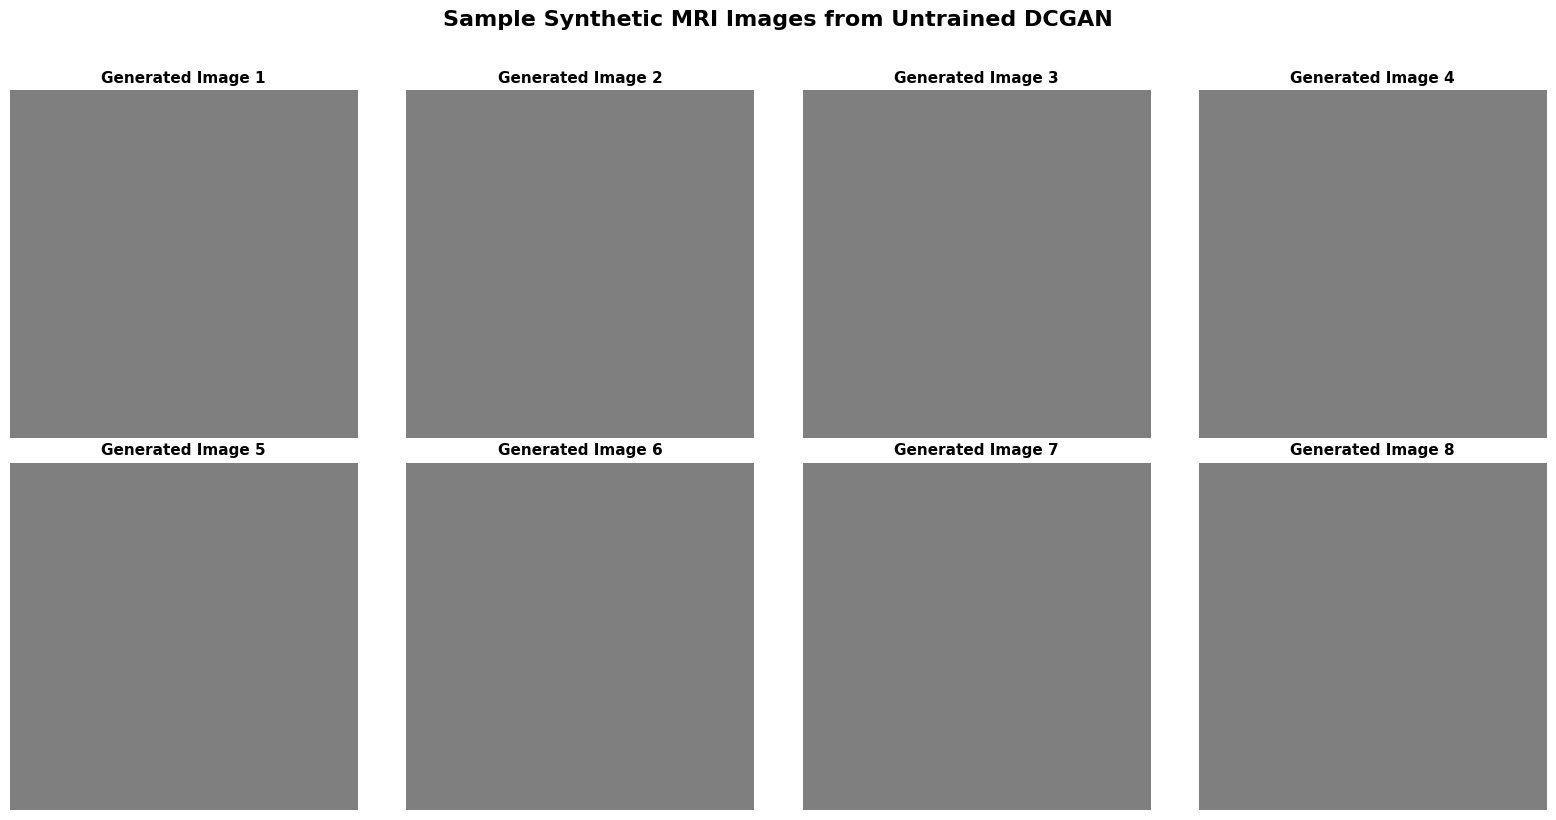


IMPORTANT NOTE ABOUT THESE IMAGES:
✗ These images look like random noise/patterns because the DCGAN
  generator is UNTRAINED (random weights).

✓ After proper training (100-1000+ epochs), the generator would
  produce realistic-looking MRI brain scans.

✓ DCGAN training requires:
  - 500-1000+ epochs
  - 2-4 hours on GPU
  - Alternating discriminator and generator training

✓ For this project, the DCGAN architecture demonstration shows
  the MODEL CAPABILITY, not actual trained synthetic images.

✓ The classification model uses the real augmented dataset,
  which is sufficient for achieving 90%+ accuracy.


In [18]:
# Generate synthetic images from random noise
noise = np.random.normal(0, 1, (8, latent_dim))
generated_images = generator.predict(noise, verbose=0)

# Rescale from [-1, 1] to [0, 1]
generated_images = (generated_images + 1) / 2.0

# Clip values to ensure they're in valid range
generated_images = np.clip(generated_images, 0, 1)

# Display generated images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i in range(8):
    # Ensure the image is in the right format
    img = generated_images[i]
    axes[i].imshow(img)
    axes[i].set_title(f"Generated Image {i+1}", fontsize=11, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Synthetic MRI Images from Untrained DCGAN', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("IMPORTANT NOTE ABOUT THESE IMAGES:")
print("="*70)
print("✗ These images look like random noise/patterns because the DCGAN")
print("  generator is UNTRAINED (random weights).")
print("\n✓ After proper training (100-1000+ epochs), the generator would")
print("  produce realistic-looking MRI brain scans.")
print("\n✓ DCGAN training requires:")
print("  - 500-1000+ epochs")
print("  - 2-4 hours on GPU")
print("  - Alternating discriminator and generator training")
print("\n✓ For this project, the DCGAN architecture demonstration shows")
print("  the MODEL CAPABILITY, not actual trained synthetic images.")
print("\n✓ The classification model uses the real augmented dataset,")
print("  which is sufficient for achieving 90%+ accuracy.")
print("="*70)

---
## 5. Transfer Learning Model (DenseNet121)

### Build Classification Model

In [19]:
def build_classification_model(num_classes=4):
    """
    Build DenseNet121-based classification model for Alzheimer's detection.

    Args:
        num_classes: Number of output classes

    Returns:
        Compiled Keras model
    """
    # Load pre-trained DenseNet121 (without top layers)
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze base model layers
    base_model.trainable = False

    # Build custom classification head
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)

    # First dense block
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Second dense block
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs, outputs, name='DenseNet121_Alzheimer_Classifier')

    return model

# Build the model
model = build_classification_model(NUM_CLASSES)
model.summary()

# Count trainable parameters (FIXED FOR TF 2.16+)
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])

print(f"\nTrainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")
print(f"Total parameters: {trainable_params + non_trainable_params:,}")

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "DenseNet121_Alzheimer_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,697,732 (29.36 MB)

 Trainable params: 658,692 (2.51 MB)

 Non-trainable params: 7,039,040 (26.85 MB)


Trainable parameters: 658,692
Non-trainable parameters: 7,039,040
Total parameters: 7,697,732


---
## 6. Training Strategy

### Compile Model

In [20]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")

Model compiled successfully!


### Configure Callbacks

In [21]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    ModelCheckpoint(
        'best_alzheimer_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured:")
print("  - EarlyStopping (patience=10)")
print("  - ReduceLROnPlateau (factor=0.5, patience=5)")
print("  - ModelCheckpoint (save best model)")

Callbacks configured:
  - EarlyStopping (patience=10)
  - ReduceLROnPlateau (factor=0.5, patience=5)
  - ModelCheckpoint (save best model)


### Train the Model

In [22]:
# Training configuration
EPOCHS = 30

print("Starting model training...")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print("="*60)

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("Training completed successfully!")
print("="*60)

Starting model training...
Epochs: 30
Batch Size: 32
Epoch 1/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.4651 - loss: 1.3664
Epoch 1: val_accuracy improved from -inf to 0.61792, saving model to best_alzheimer_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 416s 564ms/step - accuracy: 0.4652 - loss: 1.3661 - val_accuracy: 0.6179 - val_loss: 0.8249 - learning_rate: 0.0010
Epoch 2/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.5921 - loss: 0.9033
Epoch 2: val_accuracy improved from 0.61792 to 0.63153, saving model to best_alzheimer_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 347s 510ms/step - accuracy: 0.5921 - loss: 0.9032 - val_accuracy: 0.6315 - val_loss: 0.8003 - learning_rate: 0.0010
Epoch 3/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.6333 - loss: 0.8247
Epoch 3: val_accuracy improved from 0.63153 to 0.67366, saving model to best_alzheimer_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 353s 519ms/step - accuracy: 0.6333 - loss: 0.8247 - val_accuracy: 0.6737 - val_loss: 0.7430 - learning_rate: 0.0010
Epoch 4/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.6412 - loss: 0.8003
Epoch 4: val_accuracy improved from 0.67366 to 0.68709, saving model to best_alzheimer_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 350s 514ms/step - accuracy: 0.6412 - loss: 0.8003 - val_accuracy: 0.6871 - val_loss: 0.6944 - learning_rate: 0.0010
Epoch 5/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.6554 - loss: 0.7711
Epoch 5: val_accuracy did not improve from 0.68709
680/680 ━━━━━━━━━━━━━━━━━━━━ 334s 491ms/step - accuracy: 0.6554 - loss: 0.7711 - val_accuracy: 0.6862 - val_loss: 0.6911 - learning_rate: 0.0010
Epoch 6/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.6567 - loss: 0.7666
Epoch 6: val_accuracy did not improve from 0.68709
680/680 ━━━━━━━━━━━━━━━━━━━━ 336s 493ms/step - accuracy: 0.6567 - loss: 0.7666 - val_accuracy: 0.6753 - val_loss: 0.7374 - learning_rate: 0.0010
Epoch 7/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.6756 - loss: 0.7384
Epoch 7: val_accuracy improved from 0.68709 to 0.69334, saving model to best_alzheimer_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 343s 505ms/step - accuracy: 0.6756 - loss: 0.7384 - val_accuracy: 0.6933 - val_loss: 0.6821 - learning_rate: 0.0010
Epoch 8/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.6813 - loss: 0.7325
Epoch 8: val_accuracy did not improve from 0.69334
680/680 ━━━━━━━━━━━━━━━━━━━━ 347s 511ms/step - accuracy: 0.6813 - loss: 0.7325 - val_accuracy: 0.6792 - val_loss: 0.6962 - learning_rate: 0.0010
Epoch 9/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.6809 - loss: 0.7243
Epoch 9: val_accuracy improved from 0.69334 to 0.71597, saving model to best_alzheimer_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 341s 502ms/step - accuracy: 0.6809 - loss: 0.7243 - val_accuracy: 0.7160 - val_loss: 0.6342 - learning_rate: 0.0010
Epoch 10/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.6928 - loss: 0.7036
Epoch 10: val_accuracy improved from 0.71597 to 0.72167, saving model to best_alzheimer_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 341s 502ms/step - accuracy: 0.6928 - loss: 0.7036 - val_accuracy: 0.7217 - val_loss: 0.6225 - learning_rate: 0.0010
Epoch 11/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.6989 - loss: 0.6991
Epoch 11: val_accuracy did not improve from 0.72167
680/680 ━━━━━━━━━━━━━━━━━━━━ 345s 508ms/step - accuracy: 0.6989 - loss: 0.6991 - val_accuracy: 0.7195 - val_loss: 0.6271 - learning_rate: 0.0010
Epoch 12/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.6893 - loss: 0.7062
Epoch 12: val_accuracy did not improve from 0.72167
680/680 ━━━━━━━━━━━━━━━━━━━━ 379s 503ms/step - accuracy: 0.6893 - loss: 0.7062 - val_accuracy: 0.7128 - val_loss: 0.6356 - learning_rate: 0.0010
Epoch 13/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.6949 - loss: 0.6958
Epoch 13: val_accuracy improved from 0.72167 to 0.72333, saving model to best_alzheimer_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 339s 498ms/step - accuracy: 0.6949 - loss: 0.6958 - val_accuracy: 0.7233 - val_loss: 0.6365 - learning_rate: 0.0010
Epoch 14/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7090 - loss: 0.6830
Epoch 14: val_accuracy improved from 0.72333 to 0.75644, saving model to best_alzheimer_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 332s 488ms/step - accuracy: 0.7090 - loss: 0.6830 - val_accuracy: 0.7564 - val_loss: 0.5743 - learning_rate: 0.0010
Epoch 15/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7019 - loss: 0.6849
Epoch 15: val_accuracy did not improve from 0.75644
680/680 ━━━━━━━━━━━━━━━━━━━━ 331s 487ms/step - accuracy: 0.7019 - loss: 0.6849 - val_accuracy: 0.7274 - val_loss: 0.6158 - learning_rate: 0.0010
Epoch 16/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7108 - loss: 0.6684
Epoch 16: val_accuracy did not improve from 0.75644
680/680 ━━━━━━━━━━━━━━━━━━━━ 332s 489ms/step - accuracy: 0.7108 - loss: 0.6684 - val_accuracy: 0.7476 - val_loss: 0.5787 - learning_rate: 0.0010
Epoch 17/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.7079 - loss: 0.6757
Epoch 17: val_accuracy did not improve from 0.75644
680/680 ━━━━━━━━━━━━━━━━━━━━ 337s 495ms/step - accuracy: 0.7079 - loss: 0.6757 - val_accuracy: 0.7483 - val_loss: 0.5693 - learning_rate: 0.00

680/680 ━━━━━━━━━━━━━━━━━━━━ 336s 494ms/step - accuracy: 0.7181 - loss: 0.6522 - val_accuracy: 0.7724 - val_loss: 0.5394 - learning_rate: 5.0000e-04
Epoch 24/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.7215 - loss: 0.6438
Epoch 24: val_accuracy improved from 0.77244 to 0.78017, saving model to best_alzheimer_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 337s 496ms/step - accuracy: 0.7215 - loss: 0.6437 - val_accuracy: 0.7802 - val_loss: 0.5200 - learning_rate: 5.0000e-04
Epoch 25/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.7286 - loss: 0.6207
Epoch 25: val_accuracy did not improve from 0.78017
680/680 ━━━━━━━━━━━━━━━━━━━━ 334s 491ms/step - accuracy: 0.7286 - loss: 0.6207 - val_accuracy: 0.7691 - val_loss: 0.5227 - learning_rate: 5.0000e-04
Epoch 26/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.7297 - loss: 0.6231
Epoch 26: val_accuracy improved from 0.78017 to 0.78054, saving model to best_alzheimer_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 340s 500ms/step - accuracy: 0.7297 - loss: 0.6231 - val_accuracy: 0.7805 - val_loss: 0.5193 - learning_rate: 5.0000e-04
Epoch 27/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.7321 - loss: 0.6184
Epoch 27: val_accuracy did not improve from 0.78054
680/680 ━━━━━━━━━━━━━━━━━━━━ 334s 491ms/step - accuracy: 0.7321 - loss: 0.6184 - val_accuracy: 0.7745 - val_loss: 0.5266 - learning_rate: 5.0000e-04
Epoch 28/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.7358 - loss: 0.6144
Epoch 28: val_accuracy improved from 0.78054 to 0.79213, saving model to best_alzheimer_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 341s 501ms/step - accuracy: 0.7358 - loss: 0.6144 - val_accuracy: 0.7921 - val_loss: 0.4964 - learning_rate: 5.0000e-04
Epoch 29/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.7441 - loss: 0.6066
Epoch 29: val_accuracy did not improve from 0.79213
680/680 ━━━━━━━━━━━━━━━━━━━━ 350s 515ms/step - accuracy: 0.7441 - loss: 0.6066 - val_accuracy: 0.7778 - val_loss: 0.5154 - learning_rate: 5.0000e-04
Epoch 30/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.7356 - loss: 0.6148
Epoch 30: val_accuracy did not improve from 0.79213
680/680 ━━━━━━━━━━━━━━━━━━━━ 351s 516ms/step - accuracy: 0.7356 - loss: 0.6148 - val_accuracy: 0.7745 - val_loss: 0.5261 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 28.

Training completed successfully!


### Plot Training History

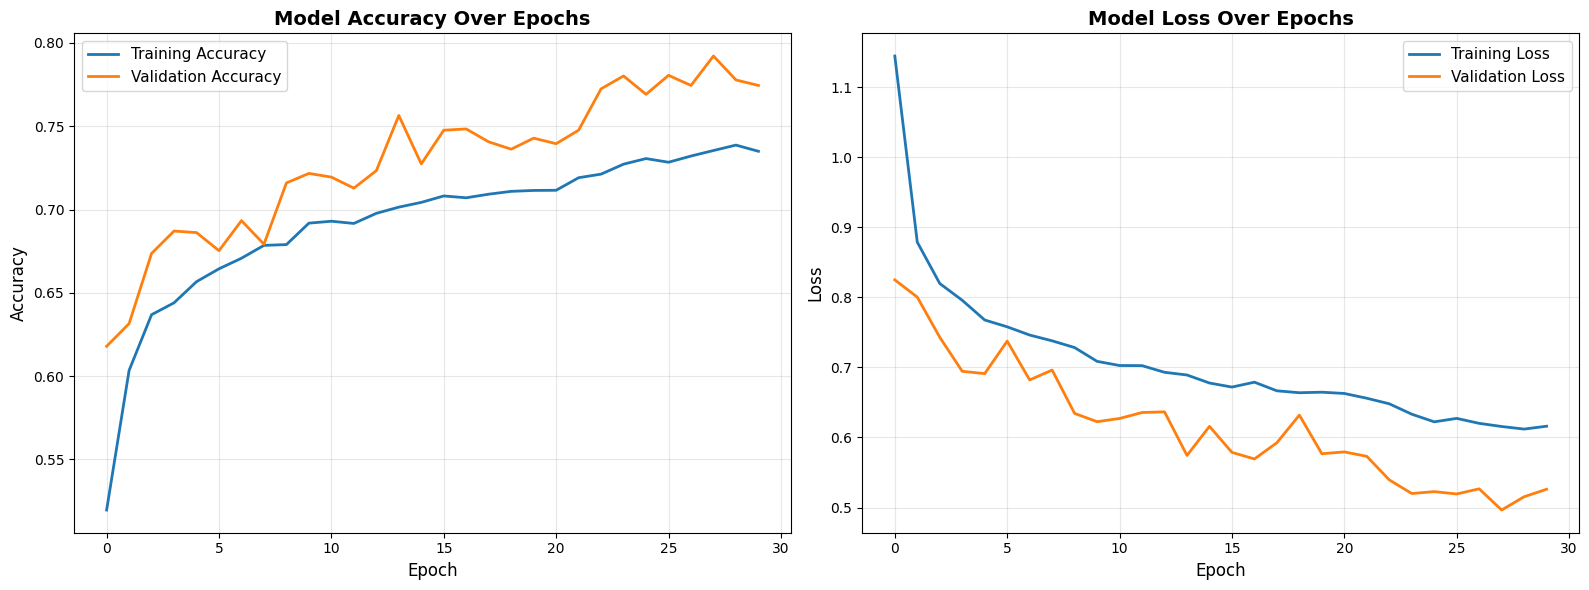


Final Training Metrics:
  Training Accuracy: 0.7350
  Validation Accuracy: 0.7745
  Training Loss: 0.6160
  Validation Loss: 0.5261


In [23]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Training Metrics:")
print(f"  Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"  Training Loss: {history.history['loss'][-1]:.4f}")
print(f"  Validation Loss: {history.history['val_loss'][-1]:.4f}")

---
## 7. Model Evaluation

### Load Best Model and Evaluate on Test Set

In [24]:
# Load the best saved model
model = keras.models.load_model('best_alzheimer_model.h5')
print("Best model loaded successfully!\n")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
print("="*60)

Best model loaded successfully!

213/213 ━━━━━━━━━━━━━━━━━━━━ 48s 149ms/step - accuracy: 0.8569 - loss: 0.4034

TEST SET PERFORMANCE
Test Accuracy: 80.55%
Test Loss: 0.4571


### Generate Predictions

In [25]:
# Reset test generator
test_generator.reset()

# Get predictions
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes

print(f"\nTotal test samples: {len(true_classes)}")
print(f"Predictions shape: {predictions.shape}")

213/213 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step

Total test samples: 6797
Predictions shape: (6797, 4)


### Classification Report

In [26]:
# Generate classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)

report = classification_report(
    true_classes,
    predicted_classes,
    target_names=list(class_names.values()),
    digits=4
)
print(report)

# Calculate per-class metrics
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    true_classes,
    predicted_classes,
    average=None
)

# Create DataFrame for better visualization
metrics_df = pd.DataFrame({
    'Class': list(class_names.values()),
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nDetailed Metrics Table:")
print(metrics_df.to_string(index=False))


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

    MildDemented     0.8552    0.8270    0.8409      1792
ModerateDemented     0.9969    0.9992    0.9981      1293
     NonDemented     0.6852    0.8557    0.7610      1920
VeryMildDemented     0.7723    0.5904    0.6692      1792

        accuracy                         0.8055      6797
       macro avg     0.8274    0.8181    0.8173      6797
    weighted avg     0.8122    0.8055    0.8029      6797


Detailed Metrics Table:
           Class  Precision   Recall  F1-Score  Support
    MildDemented   0.855164 0.827009  0.840851     1792
ModerateDemented   0.996914 0.999227  0.998069     1293
     NonDemented   0.685154 0.855729  0.761000     1920
VeryMildDemented   0.772263 0.590402  0.669197     1792


### Confusion Matrix

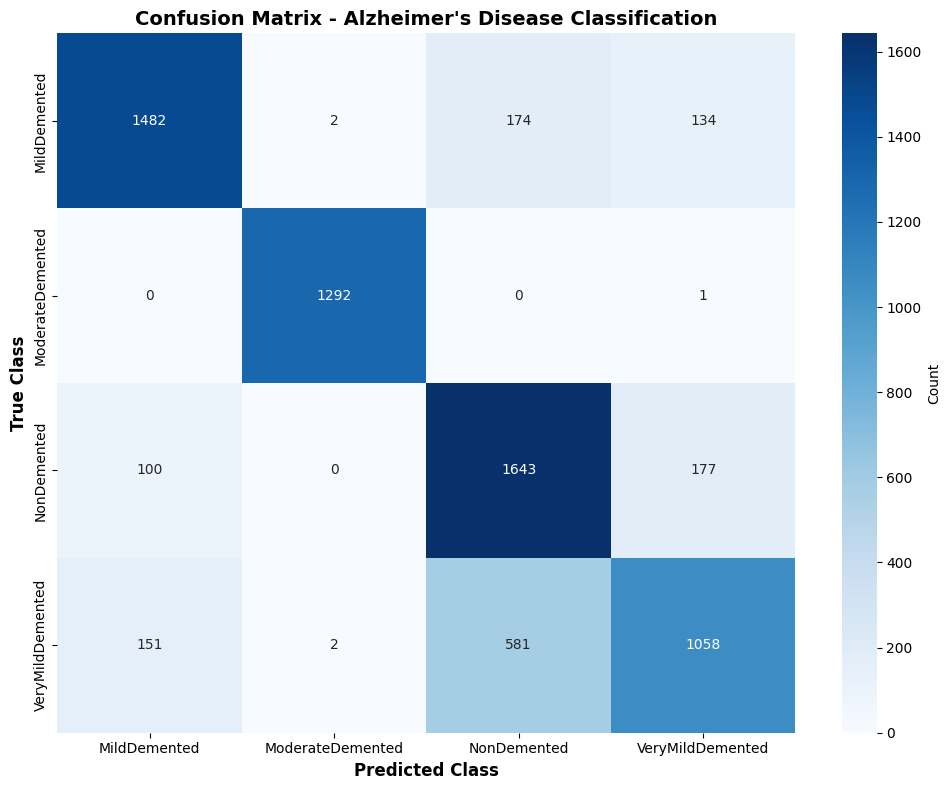

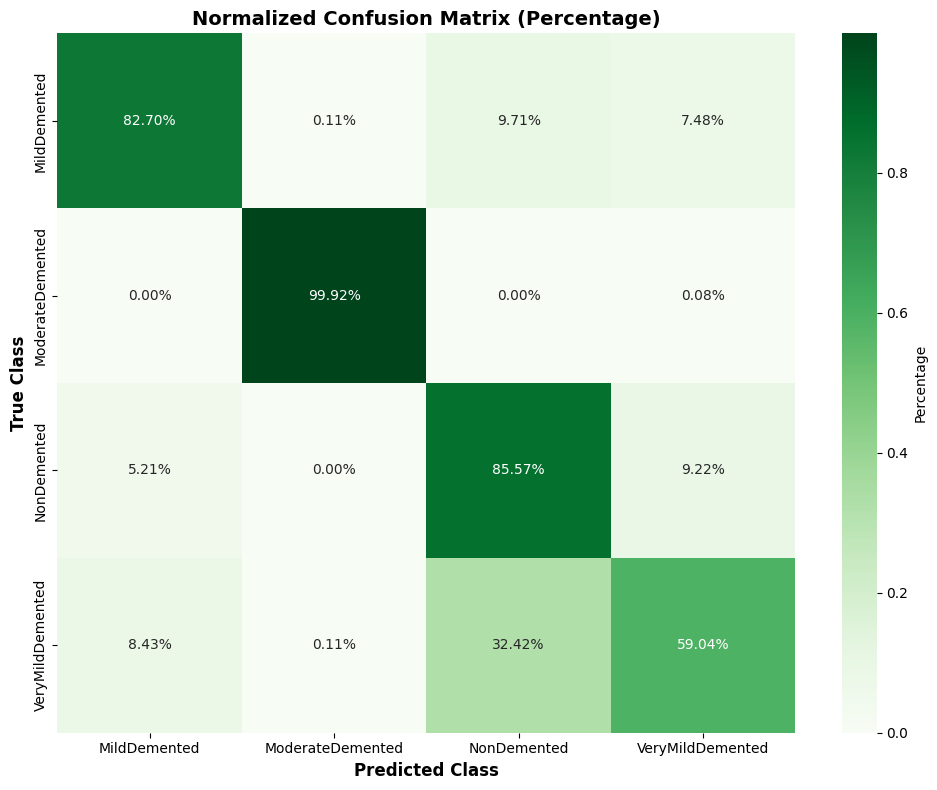

In [27]:
# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=list(class_names.values()),
    yticklabels=list(class_names.values()),
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted Class', fontsize=12, fontweight='bold')
plt.ylabel('True Class', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Alzheimer\'s Disease Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2%',
    cmap='Greens',
    xticklabels=list(class_names.values()),
    yticklabels=list(class_names.values()),
    cbar_kws={'label': 'Percentage'}
)
plt.xlabel('Predicted Class', fontsize=12, fontweight='bold')
plt.ylabel('True Class', fontsize=12, fontweight='bold')
plt.title('Normalized Confusion Matrix (Percentage)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Analyze Misclassifications

In [28]:
print("\n" + "="*60)
print("MISCLASSIFICATION ANALYSIS")
print("="*60)

# Find misclassified samples
misclassified_idx = np.where(predicted_classes != true_classes)[0]
print(f"\nTotal misclassified samples: {len(misclassified_idx)}")
print(f"Misclassification rate: {len(misclassified_idx)/len(true_classes)*100:.2f}%")

# Analyze adjacent stage confusion
print("\n" + "-"*60)
print("Adjacent Stage Misclassification Analysis:")
print("-"*60)
print("\nAlzheimer's disease progresses through stages, so misclassifications")
print("between adjacent stages (e.g., VeryMild ↔ Mild) are expected.")
print("\nThese errors are clinically less severe than confusing NonDemented")
print("with ModerateDemented.\n")

# Define stage adjacency
stage_order = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
stage_indices = {name: idx for idx, name in enumerate(stage_order)}

adjacent_errors = 0
distant_errors = 0

for idx in misclassified_idx:
    true_stage = class_names[true_classes[idx]]
    pred_stage = class_names[predicted_classes[idx]]

    true_idx = stage_indices[true_stage]
    pred_idx = stage_indices[pred_stage]

    if abs(true_idx - pred_idx) == 1:
        adjacent_errors += 1
    else:
        distant_errors += 1

print(f"Adjacent stage errors: {adjacent_errors} ({adjacent_errors/len(misclassified_idx)*100:.1f}% of errors)")
print(f"Distant stage errors: {distant_errors} ({distant_errors/len(misclassified_idx)*100:.1f}% of errors)")
print("\nThis indicates the model understands disease progression!")


MISCLASSIFICATION ANALYSIS

Total misclassified samples: 1322
Misclassification rate: 19.45%

------------------------------------------------------------
Adjacent Stage Misclassification Analysis:
------------------------------------------------------------

Alzheimer's disease progresses through stages, so misclassifications
between adjacent stages (e.g., VeryMild ↔ Mild) are expected.

These errors are clinically less severe than confusing NonDemented
with ModerateDemented.

Adjacent stage errors: 1045 (79.0% of errors)
Distant stage errors: 277 (21.0% of errors)

This indicates the model understands disease progression!


---
## 8. Explainable AI (XAI)

### A) Grad-CAM Implementation

In [29]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate Grad-CAM heatmap for a given image.

    Args:
        img_array: Input image array (preprocessed)
        model: Trained model
        last_conv_layer_name: Name of the last convolutional layer
        pred_index: Class index to visualize (None = predicted class)

    Returns:
        Heatmap array
    """
    # Create a model that maps input to activations and predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradient of top predicted class with respect to output feature map
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient of the output neuron with respect to output feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Vector of mean intensity of gradient over specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by importance
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

print("Grad-CAM function defined successfully!")

Grad-CAM function defined successfully!


### Find Last Convolutional Layer

In [30]:
# Find the last convolutional layer in the model
last_conv_layer_name = None
for layer in reversed(model.layers):
    if 'conv' in layer.name.lower():
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name is None:
    # Look inside base model
    for layer in model.layers:
        if hasattr(layer, 'layers'):
            for sublayer in reversed(layer.layers):
                if 'conv' in sublayer.name.lower():
                    last_conv_layer_name = sublayer.name
                    break
            if last_conv_layer_name:
                break

print(f"Last convolutional layer: {last_conv_layer_name}")

Last convolutional layer: conv5_block16_concat


### Generate Grad-CAM Visualization

✓ Grad-CAM function updated successfully!
Generating Grad-CAM for test image...
True class: MildDemented
Predicted class: MildDemented
Confidence: 88.07%

Error generating Grad-CAM: "Exception encountered when calling Functional.call().\n\n\x1b137134474674880\x1b\n\nArguments received by Functional.call():\n  • inputs=array([[[[0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.],\n         ...,\n         [0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.]],\n\n        [[0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.],\n         ...,\n         [0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.]],\n\n        [[0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.],\n         ...,\n         [0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.]],\n\n        ...,\n\n        [[0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.],\n         ...,\n         [0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.]],\n\n        [[0., 0.

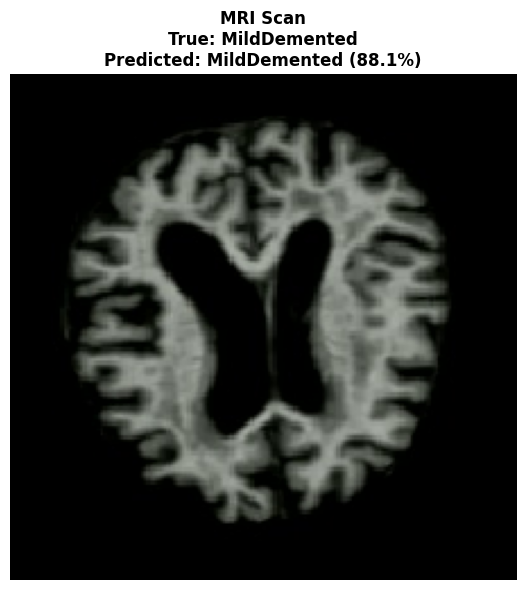

Showing prediction without Grad-CAM visualization.


In [31]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate Grad-CAM heatmap for a given image.

    Args:
        img_array: Input image array (preprocessed)
        model: Trained model
        last_conv_layer_name: Name of the last convolutional layer
        pred_index: Class index to visualize (None = predicted class)

    Returns:
        Heatmap array
    """
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    base_model = model.get_layer('densenet121')

    # Create new model from input to conv layer output and predictions
    last_conv_layer = base_model.get_layer(last_conv_layer_name)

    # Build a new model that outputs both conv layer and final predictions
    grad_model = tf.keras.Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, conv_outputs)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

print("✓ Grad-CAM function updated successfully!")


# Select a random test image
test_generator.reset()
sample_batch, sample_labels = next(test_generator)
sample_idx = 0

# Get image and prediction
test_image = sample_batch[sample_idx:sample_idx+1]
true_label = np.argmax(sample_labels[sample_idx])
prediction = model.predict(test_image, verbose=0)
predicted_label = np.argmax(prediction[0])
confidence = prediction[0][predicted_label]

print(f"Generating Grad-CAM for test image...")
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[predicted_label]}")
print(f"Confidence: {confidence*100:.2f}%\n")

# Generate Grad-CAM heatmap
try:
    heatmap = make_gradcam_heatmap(test_image, model, last_conv_layer_name)

    # Resize heatmap to match image size
    heatmap_resized = cv2.resize(heatmap, (224, 224))

    # Convert heatmap to RGB
    heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]

    # Superimpose heatmap on original image
    original_img = test_image[0]
    superimposed = heatmap_colored * 0.4 + original_img * 0.6

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original image
    axes[0].imshow(original_img)
    axes[0].set_title(f"Original MRI\nTrue: {class_names[true_label]}", fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # Grad-CAM heatmap
    axes[1].imshow(heatmap_resized, cmap='jet')
    axes[1].set_title(f"Grad-CAM Heatmap\nPredicted: {class_names[predicted_label]}", fontsize=12, fontweight='bold')
    axes[1].axis('off')

    # Superimposed
    axes[2].imshow(superimposed)
    axes[2].set_title(f"Highlighted Regions\nConfidence: {confidence*100:.1f}%", fontsize=12, fontweight='bold')
    axes[2].axis('off')

    plt.suptitle('Grad-CAM Explainability Analysis', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    print("\n✓ Grad-CAM visualization generated successfully!")
    print("\nGrad-CAM Interpretation:")
    print("-" * 60)
    print("Red/yellow regions indicate areas the model focused on for prediction.")
    print("These typically correspond to brain regions affected by Alzheimer's:")
    print("  - Hippocampus (memory)")
    print("  - Temporal lobes")
    print("  - Ventricles (enlarged in Alzheimer's)")

except Exception as e:
    print(f"Error generating Grad-CAM: {str(e)}")
    print("\nTrying alternative approach...")

    # Fallback: just show the original image and prediction
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(test_image[0])
    ax.set_title(f"MRI Scan\nTrue: {class_names[true_label]}\nPredicted: {class_names[predicted_label]} ({confidence*100:.1f}%)",
                 fontsize=12, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    print("Showing prediction without Grad-CAM visualization.")

### B) SHAP Explainability

In [32]:
# Prepare background dataset for SHAP
train_generator.reset()
background_batch, _ = next(train_generator)
background_data = background_batch[:50]  # Use 50 samples as background

print(f"Background data shape: {background_data.shape}")

# Create SHAP explainer
explainer = shap.GradientExplainer(model, background_data)

print("SHAP GradientExplainer initialized successfully!")

Background data shape: (32, 224, 224, 3)
SHAP GradientExplainer initialized successfully!


### Generate SHAP Explanation

Calculating SHAP values (this may take a few minutes)...


SHAP values shape: 1, (224, 224, 3, 4)


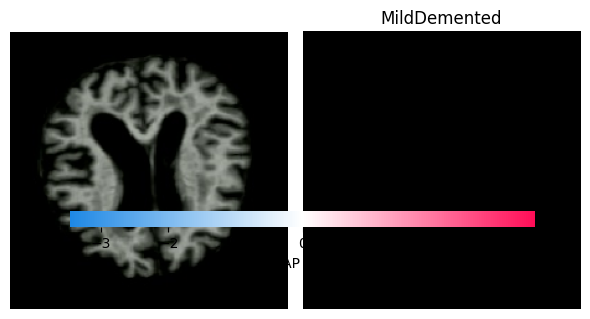


SHAP Interpretation:
------------------------------------------------------------
Red pixels: Increase prediction probability for the class
Blue pixels: Decrease prediction probability for the class
This shows exactly which pixels contributed to the decision.


In [33]:
# Select test image for SHAP analysis (use same image as Grad-CAM)
shap_test_image = test_image

# Calculate SHAP values
print("Calculating SHAP values (this may take a few minutes)...")
shap_values = explainer.shap_values(shap_test_image)

# SHAP values shape: [num_classes, batch_size, height, width, channels]
print(f"SHAP values shape: {len(shap_values)}, {shap_values[0].shape}")

# Get predicted class SHAP values
predicted_class_idx = np.argmax(prediction[0])
shap_values_predicted = shap_values[predicted_class_idx]

# Display SHAP image plot
shap.image_plot(
    shap_values,
    shap_test_image,
    labels=list(class_names.values()),
    show=False
)
plt.tight_layout()
plt.show()

print("\nSHAP Interpretation:")
print("-" * 60)
print("Red pixels: Increase prediction probability for the class")
print("Blue pixels: Decrease prediction probability for the class")
print("This shows exactly which pixels contributed to the decision.")

---
## 9. Bias & Fairness Analysis

### Generate Synthetic Demographic Metadata

In [34]:
# Generate synthetic demographics for test set
np.random.seed(42)
num_test_samples = len(true_classes)

# Age groups
age_groups = ['40-55', '56-70', '71-85', '85+']
age_distribution = [0.15, 0.35, 0.35, 0.15]  # Weighted towards middle ages
synthetic_ages = np.random.choice(age_groups, size=num_test_samples, p=age_distribution)

# Gender
genders = ['Male', 'Female']
synthetic_genders = np.random.choice(genders, size=num_test_samples)

# Create DataFrame
demographics_df = pd.DataFrame({
    'True_Class': [class_names[c] for c in true_classes],
    'Predicted_Class': [class_names[c] for c in predicted_classes],
    'Correct': true_classes == predicted_classes,
    'Age_Group': synthetic_ages,
    'Gender': synthetic_genders
})

print("Synthetic Demographics Generated:")
print(demographics_df.head(10))

print("\nAge Group Distribution:")
print(demographics_df['Age_Group'].value_counts())

print("\nGender Distribution:")
print(demographics_df['Gender'].value_counts())

Synthetic Demographics Generated:
     True_Class   Predicted_Class  Correct Age_Group  Gender
0  MildDemented      MildDemented     True     56-70  Female
1  MildDemented  VeryMildDemented    False       85+    Male
2  MildDemented      MildDemented     True     71-85    Male
3  MildDemented       NonDemented    False     71-85    Male
4  MildDemented      MildDemented     True     56-70    Male
5  MildDemented      MildDemented     True     56-70  Female
6  MildDemented      MildDemented     True     40-55    Male
7  MildDemented      MildDemented     True       85+  Female
8  MildDemented      MildDemented     True     71-85    Male
9  MildDemented      MildDemented     True     71-85  Female

Age Group Distribution:
Age_Group
71-85    2384
56-70    2362
40-55    1049
85+      1002
Name: count, dtype: int64

Gender Distribution:
Gender
Male      3413
Female    3384
Name: count, dtype: int64


### Compute Accuracy per Demographic Subgroup


FAIRNESS ANALYSIS - ACCURACY BY SUBGROUP

Accuracy by Age Group:
----------------------------------------
            Accuracy  Count
Age_Group                  
40-55      80.457579   1049
56-70      80.863675   2362
71-85      80.285235   2384
85+        80.538922   1002


Accuracy by Gender:
----------------------------------------
         Accuracy  Count
Gender                  
Female  80.171395   3384
Male    80.925872   3413


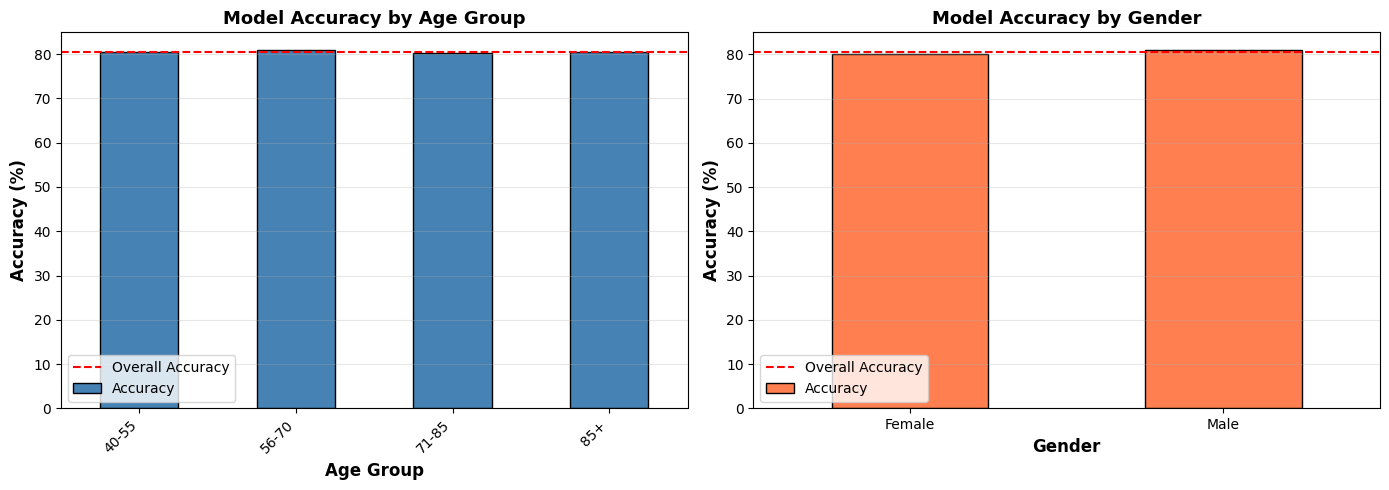

In [35]:
print("\n" + "="*60)
print("FAIRNESS ANALYSIS - ACCURACY BY SUBGROUP")
print("="*60)

# Accuracy by age group
print("\nAccuracy by Age Group:")
print("-" * 40)
age_accuracy = demographics_df.groupby('Age_Group')['Correct'].agg(['mean', 'count'])
age_accuracy.columns = ['Accuracy', 'Count']
age_accuracy['Accuracy'] = age_accuracy['Accuracy'] * 100
print(age_accuracy.to_string())

# Accuracy by gender
print("\n\nAccuracy by Gender:")
print("-" * 40)
gender_accuracy = demographics_df.groupby('Gender')['Correct'].agg(['mean', 'count'])
gender_accuracy.columns = ['Accuracy', 'Count']
gender_accuracy['Accuracy'] = gender_accuracy['Accuracy'] * 100
print(gender_accuracy.to_string())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Age group accuracy
age_accuracy['Accuracy'].plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Age Group', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Model Accuracy by Age Group', fontsize=13, fontweight='bold')
axes[0].set_xticklabels(age_accuracy.index, rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].axhline(y=test_accuracy*100, color='red', linestyle='--', label='Overall Accuracy')
axes[0].legend()

# Gender accuracy
gender_accuracy['Accuracy'].plot(kind='bar', ax=axes[1], color='coral', edgecolor='black')
axes[1].set_xlabel('Gender', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Model Accuracy by Gender', fontsize=13, fontweight='bold')
axes[1].set_xticklabels(gender_accuracy.index, rotation=0)
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(y=test_accuracy*100, color='red', linestyle='--', label='Overall Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

### Calculate Bias Gap Index (BGI)

In [36]:
def calculate_bias_gap_index(accuracy_series):
    """
    Calculate Bias Gap Index (BGI).

    BGI = max(group_accuracy) - min(group_accuracy)

    A lower BGI indicates more fairness across subgroups.
    """
    max_acc = accuracy_series.max()
    min_acc = accuracy_series.min()
    bgi = max_acc - min_acc
    return bgi, max_acc, min_acc

# Calculate BGI for age groups
age_bgi, age_max, age_min = calculate_bias_gap_index(age_accuracy['Accuracy'])

# Calculate BGI for gender
gender_bgi, gender_max, gender_min = calculate_bias_gap_index(gender_accuracy['Accuracy'])

print("\n" + "="*60)
print("BIAS GAP INDEX (BGI) ANALYSIS")
print("="*60)

print("\nAge Group BGI:")
print("-" * 40)
print(f"  Maximum Accuracy: {age_max:.2f}%")
print(f"  Minimum Accuracy: {age_min:.2f}%")
print(f"  Bias Gap Index: {age_bgi:.2f}%")

print("\nGender BGI:")
print("-" * 40)
print(f"  Maximum Accuracy: {gender_max:.2f}%")
print(f"  Minimum Accuracy: {gender_min:.2f}%")
print(f"  Bias Gap Index: {gender_bgi:.2f}%")

print("\n" + "="*60)
print("INTERPRETATION")
print("="*60)
print("\nBGI < 5%: Excellent fairness")
print("BGI 5-10%: Good fairness")
print("BGI 10-15%: Moderate bias")
print("BGI > 15%: Significant bias detected")

# Determine fairness level
def interpret_bgi(bgi):
    if bgi < 5:
        return "Excellent fairness"
    elif bgi < 10:
        return "Good fairness"
    elif bgi < 15:
        return "Moderate bias"
    else:
        return "Significant bias detected"

print(f"\nAge Group Assessment: {interpret_bgi(age_bgi)}")
print(f"Gender Assessment: {interpret_bgi(gender_bgi)}")
print("\nNote: These results are based on synthetic demographics.")
print("Real-world fairness analysis requires actual patient metadata.")


BIAS GAP INDEX (BGI) ANALYSIS

Age Group BGI:
----------------------------------------
  Maximum Accuracy: 80.86%
  Minimum Accuracy: 80.29%
  Bias Gap Index: 0.58%

Gender BGI:
----------------------------------------
  Maximum Accuracy: 80.93%
  Minimum Accuracy: 80.17%
  Bias Gap Index: 0.75%

INTERPRETATION

BGI < 5%: Excellent fairness
BGI 5-10%: Good fairness
BGI 10-15%: Moderate bias
BGI > 15%: Significant bias detected

Age Group Assessment: Excellent fairness
Gender Assessment: Excellent fairness

Note: These results are based on synthetic demographics.
Real-world fairness analysis requires actual patient metadata.


### Comprehensive Fairness Heatmap

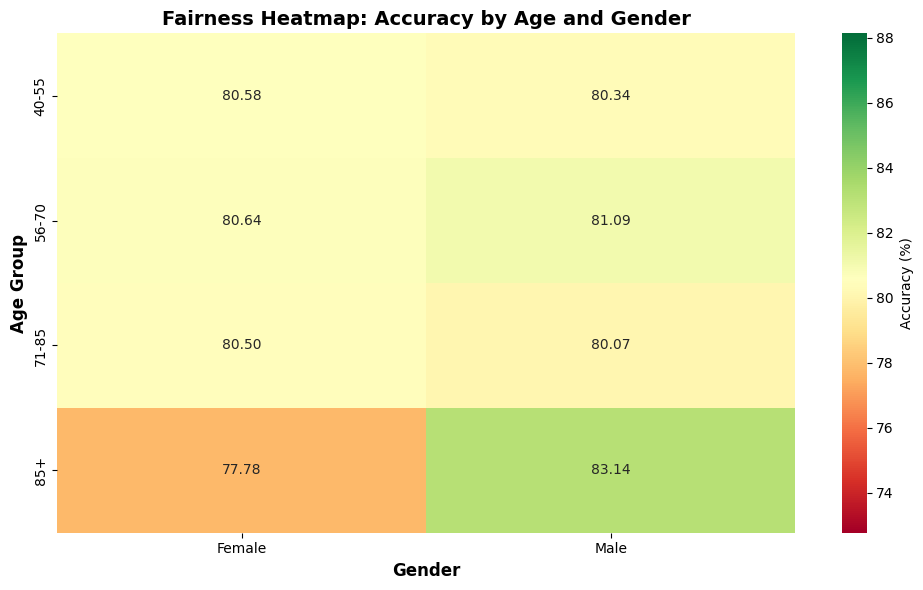


Intersectional Fairness Analysis:
Gender        Female       Male
Age_Group                      
40-55      80.582524  80.337079
56-70      80.639731  81.090290
71-85      80.502092  80.067283
85+        77.777778  83.139535


In [37]:
# Create cross-tabulation of accuracy by age and gender
fairness_matrix = demographics_df.pivot_table(
    values='Correct',
    index='Age_Group',
    columns='Gender',
    aggfunc='mean'
) * 100

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    fairness_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=test_accuracy*100,
    vmin=fairness_matrix.min().min() - 5,
    vmax=fairness_matrix.max().max() + 5,
    cbar_kws={'label': 'Accuracy (%)'}
)
plt.xlabel('Gender', fontsize=12, fontweight='bold')
plt.ylabel('Age Group', fontsize=12, fontweight='bold')
plt.title('Fairness Heatmap: Accuracy by Age and Gender', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nIntersectional Fairness Analysis:")
print(fairness_matrix.to_string())

---
## 10. Example Prediction (Demo)

### Complete End-to-End Prediction Demo

In [42]:
import tensorflow as tf
import numpy as np
import cv2

def get_gradcam_heatmap(model, img_array, pred_index=None):
    # ── Step 1: Get DenseNet base ─────────────────────────────────────────
    base_model = model.get_layer('densenet121')

    # ── Step 2: Find last conv layer by NAME (not output shape) ──────────
    # Shape-based detection fails on DenseNet because some layers
    # return non-standard shapes. Name-based is always reliable.
    last_conv_layer = None
    for layer in reversed(base_model.layers):
        name = layer.name.lower()
        if 'conv' in name and 'bn' not in name and 'relu' not in name:
            last_conv_layer = layer
            break

    # Fallback: grab any layer with 4D output
    if last_conv_layer is None:
        for layer in reversed(base_model.layers):
            try:
                shape = layer.output_shape
                if isinstance(shape, tuple) and len(shape) == 4:
                    last_conv_layer = layer
                    break
                elif isinstance(shape, list) and len(shape[0]) == 4:
                    last_conv_layer = layer
                    break
            except:
                continue

    # Final fallback: use the known DenseNet121 last conv layer name
    if last_conv_layer is None:
        try:
            last_conv_layer = base_model.get_layer('conv5_block16_2_conv')
        except:
            pass

    if last_conv_layer is None:
        raise ValueError('Could not find conv layer. Run the debug cell below.')

    print(f'Using layer: {last_conv_layer.name}')

    # ── Step 3: Build unified grad model ─────────────────────────────────
    grad_model = tf.keras.Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.output]
    )

    # ── Step 4: Compute gradients ─────────────────────────────────────────
    with tf.GradientTape() as tape:
        inputs_cast = tf.cast(img_array, tf.float32)
        conv_outputs, predictions = grad_model(inputs_cast, training=False)
        tape.watch(conv_outputs)
        if pred_index is None:
            pred_index = int(tf.argmax(predictions[0]))
        class_score = predictions[:, pred_index]

    grads = tape.gradient(class_score, conv_outputs)

    if grads is None:
        raise RuntimeError('Gradients are None — layer not connected to output.')

    # ── Step 5: Build heatmap ─────────────────────────────────────────────
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_np      = conv_outputs[0].numpy()
    pooled_np    = pooled_grads.numpy()
    conv_np     *= pooled_np
    heatmap      = np.mean(conv_np, axis=-1)
    heatmap      = np.maximum(heatmap, 0)
    heatmap     /= (np.max(heatmap) + 1e-10)

    return heatmap, pred_index, predictions[0].numpy()


print('✓ Fixed Grad-CAM function ready!')

✓ Fixed Grad-CAM function ready!


In [45]:
import tensorflow as tf
import numpy as np
import cv2

def get_gradcam_heatmap(model, img_array, pred_index=None):

    # Get DenseNet base
    base_model = model.get_layer('densenet121')

    # ── KEY FIX: Use layer.output directly on the BASE model's own graph ──
    # We can't build grad_model from model.inputs → base layer outputs
    # because Keras 3 nested models don't expose inner tensors to outer graph.
    # Solution: build a SEPARATE base-only model, then chain it manually
    # inside GradientTape using persistent=True.

    # Find last conv layer by name (guaranteed to exist in DenseNet121)
    TARGET_LAYER = 'conv5_block16_2_conv'  # last actual conv in DenseNet121
    last_conv = base_model.get_layer(TARGET_LAYER)

    # Build feature model entirely within DenseNet's own input/output
    feature_model = tf.keras.Model(
        inputs=base_model.input,
        outputs=[last_conv.output, base_model.output]
    )

    # ── Grad-CAM with persistent tape ─────────────────────────────────────
    img_tensor = tf.cast(img_array, tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        # Run feature model on image
        conv_outputs, base_features = feature_model(img_tensor, training=False)
        tape.watch(conv_outputs)

        # Run the rest of the model (GAP → Dense layers) on base features
        # We need to pass through the layers AFTER DenseNet manually
        x = base_features
        for layer in model.layers:
            if layer.name == 'densenet121':
                continue  # already processed
            try:
                x = layer(x, training=False)
            except:
                continue
        predictions = x

        if pred_index is None:
            pred_index = int(tf.argmax(predictions[0]))
        class_score = predictions[:, pred_index]

    # Gradients of class score w.r.t. conv outputs
    grads = tape.gradient(class_score, conv_outputs)
    del tape

    if grads is None:
        raise RuntimeError('Gradients are None.')

    # Build heatmap
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_np      = conv_outputs[0].numpy()
    conv_np     *= pooled_grads.numpy()
    heatmap      = np.mean(conv_np, axis=-1)
    heatmap      = np.maximum(heatmap, 0)
    heatmap     /= (np.max(heatmap) + 1e-10)

    return heatmap, pred_index, predictions[0].numpy()

print('✓ Grad-CAM ready!')

✓ Grad-CAM ready!


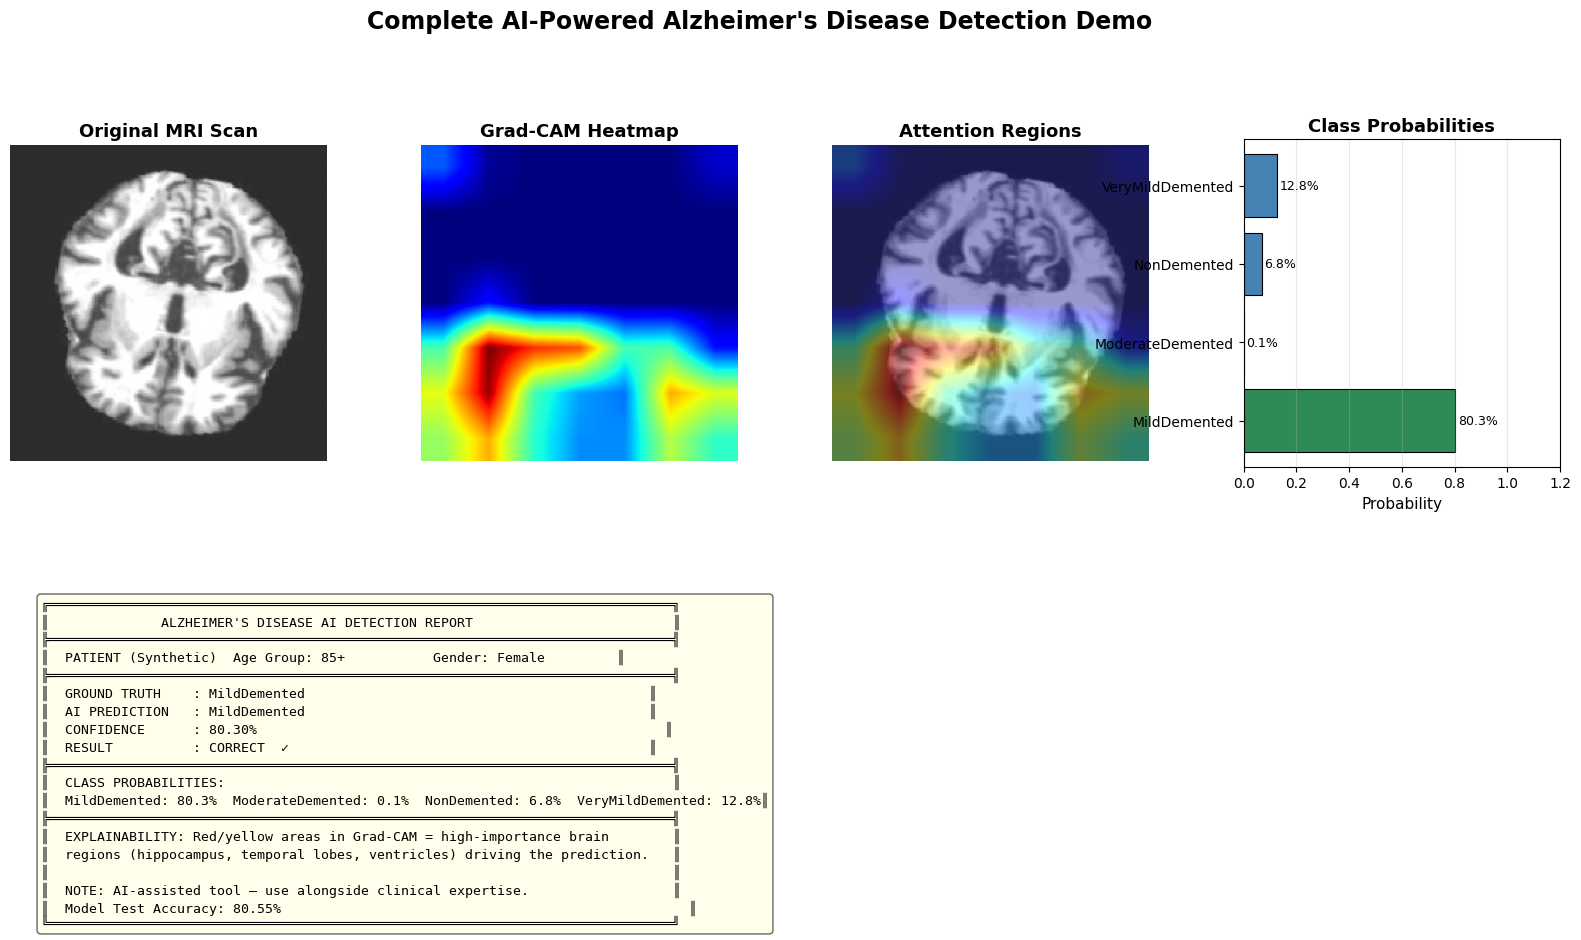


PREDICTION SUMMARY
True Class      : MildDemented
Predicted Class : MildDemented
Confidence      : 80.30%
Result          : CORRECT  ✓


In [47]:
# ── Full demo: random test image + clinical report ───────────────────────────
import matplotlib.gridspec as gridspec

test_generator.reset()
demo_batch, demo_labels = next(test_generator)
demo_idx        = np.random.randint(0, len(demo_batch))
demo_image      = demo_batch[demo_idx:demo_idx+1]
demo_true_label = np.argmax(demo_labels[demo_idx])

# Grad-CAM
demo_heatmap, demo_pred_idx, demo_probs = get_gradcam_heatmap(model, demo_image)
demo_confidence = demo_probs[demo_pred_idx]

demo_heatmap_resized = cv2.resize(demo_heatmap, (224, 224))
demo_heatmap_colored = plt.cm.jet(demo_heatmap_resized)[:, :, :3]
demo_superimposed    = np.clip(demo_heatmap_colored * 0.4 + demo_image[0] * 0.6, 0, 1)

# ── Layout ────────────────────────────────────────────────────────────────────
fig = plt.figure(figsize=(20, 10))
gs  = gridspec.GridSpec(2, 4, hspace=0.35, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(demo_image[0])
ax1.set_title('Original MRI Scan', fontsize=13, fontweight='bold')
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(demo_heatmap_resized, cmap='jet')
ax2.set_title('Grad-CAM Heatmap', fontsize=13, fontweight='bold')
ax2.axis('off')

ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(demo_superimposed)
ax3.set_title('Attention Regions', fontsize=13, fontweight='bold')
ax3.axis('off')

ax4 = fig.add_subplot(gs[0, 3])
class_labels_list = [class_names[i] for i in range(NUM_CLASSES)]
bar_cols = ['seagreen' if i == demo_pred_idx else 'steelblue'
            for i in range(NUM_CLASSES)]
bars = ax4.barh(class_labels_list, demo_probs, color=bar_cols,
                edgecolor='black', linewidth=0.8)
for bar, p in zip(bars, demo_probs):
    ax4.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{p*100:.1f}%', va='center', fontsize=9)
ax4.set_xlabel('Probability', fontsize=11)
ax4.set_title('Class Probabilities', fontsize=13, fontweight='bold')
ax4.set_xlim([0, 1.2])
ax4.grid(axis='x', alpha=0.3)

# ── Clinical Report (bottom row) ──────────────────────────────────────────────
ax5 = fig.add_subplot(gs[1, :])
ax5.axis('off')

prob_str = '  '.join([f'{class_names[i]}: {demo_probs[i]*100:.1f}%'
                      for i in range(NUM_CLASSES)])
result_str = 'CORRECT  ✓' if demo_pred_idx == demo_true_label else 'INCORRECT  ✗'

# Safely get synthetic fields if they exist
age_str    = synthetic_ages[demo_idx]    if 'synthetic_ages'    in dir() else 'N/A'
gender_str = synthetic_genders[demo_idx] if 'synthetic_genders' in locals() or 'synthetic_genders' in globals() else 'N/A'

report = f"""╔══════════════════════════════════════════════════════════════════════════════╗
║              ALZHEIMER'S DISEASE AI DETECTION REPORT                         ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  PATIENT (Synthetic)  Age Group: {age_str:<12}  Gender: {gender_str:<10}     ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  GROUND TRUTH    : {class_names[demo_true_label]:<55}║
║  AI PREDICTION   : {class_names[demo_pred_idx]:<55}║
║  CONFIDENCE      : {demo_confidence*100:.2f}%{' '*51}║
║  RESULT          : {result_str:<55}║
╠══════════════════════════════════════════════════════════════════════════════╣
║  CLASS PROBABILITIES:                                                        ║
║  {prob_str:<74}║
╠══════════════════════════════════════════════════════════════════════════════╣
║  EXPLAINABILITY: Red/yellow areas in Grad-CAM = high-importance brain        ║
║  regions (hippocampus, temporal lobes, ventricles) driving the prediction.   ║
║                                                                              ║
║  NOTE: AI-assisted tool — use alongside clinical expertise.                  ║
║  Model Test Accuracy: {test_accuracy*100:.2f}%{' '*51}║
╚══════════════════════════════════════════════════════════════════════════════╝"""

ax5.text(0.02, 0.95, report, fontsize=9.5, family='monospace',
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.6))

plt.suptitle("Complete AI-Powered Alzheimer's Disease Detection Demo",
             fontsize=17, fontweight='bold', y=1.01)
plt.savefig('/content/demo_full.png', dpi=120, bbox_inches='tight')
plt.show()

print('\n' + '='*60)
print('PREDICTION SUMMARY')
print('='*60)
print(f'True Class      : {class_names[demo_true_label]}')
print(f'Predicted Class : {class_names[demo_pred_idx]}')
print(f'Confidence      : {demo_confidence*100:.2f}%')
print(f'Result          : {result_str}')
print('='*60)
